In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

# this will be used to access the bigquery client
from google.cloud import bigquery
# this will be used to access the service account modules - passwords and access tokens
from google.oauth2 import service_account
# this will be used for returning data, increases the speed
from google.cloud import bigquery_storage
# for os library
import os

# required for certain returns
import pandas_gbq
# exception for a short script
from google.api_core.exceptions import NotFound

In [3]:
# pip install xgboost

In [4]:
# pip install scikit-learn

In [5]:
# Path to service account if stored locally
SERVICE_ACCOUNT_JSON = r"..\portfolio2026-485323-70c4d609b156.json"

# Credentials to access Big Query via the service account
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_JSON)

# BigQuery client
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# BigQuery Storage client
bq_storage_client = bigquery_storage.BigQueryReadClient(credentials=credentials)

# Query the complete data set
query = """
SELECT *
FROM `portfolio2026-485323.portfolio1.nba_data`
"""

# Execute the query and use the bqstorage for faster data retrieval
df = client.query(query).to_dataframe(bqstorage_client=bq_storage_client)

# Dsiplay the data
display(df.head())

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,trb,ast,stl,blk,tov,pf,pts,year,trp_dbl,awards
0,26,LaMelo Ball,PG,19,CHO,51,31,1469,293,672,...,302,313,81,18,145,136,803,2021,NaN,NaN
1,92,Vernon Carey Jr.,C,19,CHO,19,4,115,18,36,...,27,2,1,5,5,13,46,2021,NaN,NaN
2,141,Anthony Edwards,SG,19,MIN,72,55,2314,505,1211,...,336,211,82,36,160,129,1392,2021,NaN,NaN
3,199,R.J. Hampton,SG,19,TOT,51,1,888,136,313,...,179,87,21,10,53,61,354,2021,NaN,NaN
4,199,R.J. Hampton,SG,19,DEN,25,0,233,25,60,...,50,14,5,2,11,22,64,2021,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 33 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rk       2931 non-null   Int64  
 1   player   2931 non-null   object 
 2   pos      2931 non-null   object 
 3   age      2931 non-null   Int64  
 4   tm       2931 non-null   object 
 5   g        2931 non-null   Int64  
 6   gs       2931 non-null   Int64  
 7   mp       2931 non-null   Int64  
 8   fg       2931 non-null   Int64  
 9   fga      2931 non-null   Int64  
 10  fg_      2907 non-null   float64
 11  3p       2931 non-null   Int64  
 12  3pa      2931 non-null   Int64  
 13  3p_      2755 non-null   float64
 14  2p       2931 non-null   Int64  
 15  2pa      2931 non-null   Int64  
 16  2p_      2879 non-null   float64
 17  efg_     2907 non-null   float64
 18  ft       2931 non-null   Int64  
 19  fta      2931 non-null   Int64  
 20  ft_      2726 non-null   float64
 21  orb      2931 

# Dimension Reduction

In [7]:
#remove players with less than 50 games
df50 = df[df['g'] >=50].copy()

df50.reset_index(drop=True, inplace=True) # reset index after dropping rows

In [8]:
df50.shape

(1157, 33)

In [9]:
df50.head()

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,trb,ast,stl,blk,tov,pf,pts,year,trp_dbl,awards
0,26,LaMelo Ball,PG,19,CHO,51,31,1469,293,672,...,302,313,81,18,145,136,803,2021,NaN,NaN
1,141,Anthony Edwards,SG,19,MIN,72,55,2314,505,1211,...,336,211,82,36,160,129,1392,2021,NaN,NaN
2,199,R.J. Hampton,SG,19,TOT,51,1,888,136,313,...,179,87,21,10,53,61,354,2021,NaN,NaN
3,296,Kira Lewis Jr.,PG,19,NOP,54,0,904,130,337,...,71,124,38,10,34,88,343,2021,NaN,NaN
4,309,Théo Maledon,PG,19,OKC,65,49,1778,226,614,...,211,227,56,11,141,126,658,2021,NaN,NaN


In [10]:
df50.drop(columns='awards', inplace=True)
df50['trp_dbl'] = df50['trp_dbl'].fillna(0)

In [11]:
#no null values
df50.isnull().sum().sum()

np.int64(20)

In [12]:
df50.shape

(1157, 32)

## These 20 players do not have a 3 point shot percentage

They also did not take a 3 point attempt so it is not accurate to list them as having 0% for the 3 point shot

In [13]:
df50[df50['3p_'].isna()][['player', 'fg','fga','3pa']]

,player,fg,fga,3pa
139,Jalen Duren,378,546,0
162,Daniel Gafford,154,225,0
293,Mitchell Robinson,261,343,0
386,Tony Bradley,72,123,0
403,Nick Richards,60,90,0
409,Ivica Zubac,310,495,0
419,Daniel Gafford,289,395,0
434,Mitchell Robinson,188,280,0
495,Jakob Poeltl,265,430,0
579,Clint Capela,413,695,0


# An NBA season is 82 games
A player cannot play more than 82 games unless they were traded

In [14]:
df50[df50['g'] >82]

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,drb,trb,ast,stl,blk,tov,pf,pts,year,trp_dbl
625,58,Mikal Bridges,SF-SG,26,TOT,83,83,2963,593,1267,...,285,364,273,91,61,127,159,1671,2023,0.0


# Games played and Minutes played should have a positive correlation.

As a player playsm more games they will often have more minutes available to play. Now each player plays a different amount of minutes as a team divides minutes among their players based on performance and other considerations, like rest or matchups.

In [15]:
correlation_df_ex = df50[['g','mp']].corr()
correlation_mp_g = round(correlation_df_ex.iloc[1,0],2)
correlation_mp_g

np.float64(0.62)

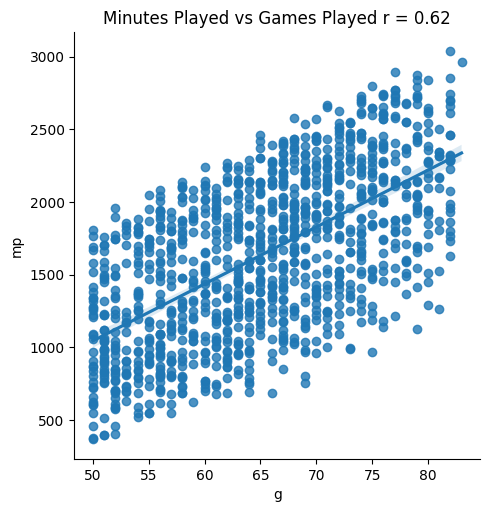

In [16]:
sns.lmplot(data=df50, x='g', y='mp')
plt.title(f'Minutes Played vs Games Played r = {correlation_mp_g}');

In [17]:
#select dtypes = numeric
df50_numeric = df50.select_dtypes('number').drop(columns=['age', 'year'])

In [18]:
df50_numeric.corr().head()

,rk,g,gs,mp,fg,fga,fg_,3p,3pa,3p_,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,trp_dbl
rk,1.000000,-0.101193,-0.185436,-0.219511,-0.216733,-0.214525,0.001980,-0.169601,-0.170257,-0.014878,...,-0.048980,-0.141015,-0.121045,-0.124019,-0.164285,-0.069821,-0.148209,-0.046781,-0.221644,-0.124771
g,-0.101193,1.000000,0.364124,0.619799,0.387467,0.385393,0.079721,0.332462,0.336441,0.067898,...,0.263101,0.375608,0.365617,0.260142,0.406681,0.228280,0.295691,0.538339,0.372033,0.041058
gs,-0.185436,0.364124,1.000000,0.838828,0.727465,0.704397,0.150410,0.407201,0.419334,0.027109,...,0.341405,0.611402,0.566846,0.554432,0.556607,0.345983,0.639639,0.589091,0.713193,0.103493
mp,-0.219511,0.619799,0.838828,1.000000,0.844899,0.851567,0.039058,0.607157,0.623333,0.160443,...,0.260159,0.635096,0.558040,0.654792,0.675536,0.272977,0.725036,0.645006,0.840649,0.122297
fg,-0.216733,0.387467,0.727465,0.844899,1.000000,0.970416,0.149001,0.554140,0.572061,0.135587,...,0.250064,0.655068,0.569636,0.684202,0.544139,0.250545,0.831983,0.505185,0.988344,0.183410


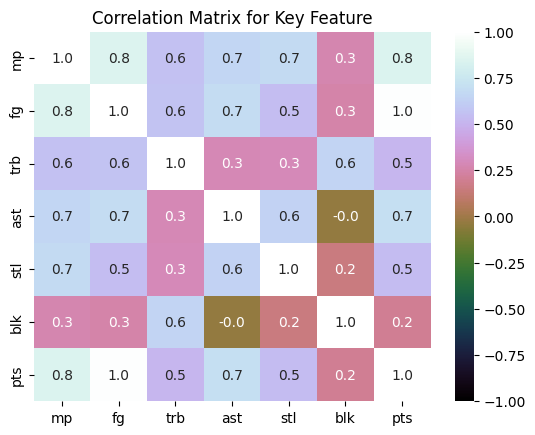

In [19]:
sns.heatmap(df50_numeric[['mp', 'fg', 'trb', 'ast', 'stl', 'blk', 'pts']].corr(),annot=True, fmt=".1f", cmap = 'cubehelix', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Key Feature');

# Remove NA values for PCA

NA values need to be removed for to perform Principal Components Analysis. PCA is a vital tool for dimension reduction, reducing the effect of colinearity. We see above that some of our variables are correlated around .8 or more. Therefore, these variables provide a similar signal and reduce the benefit of having more variables.

PCA finds the main components that explain variance by a method of dimension reduction based in linear algebra.

In this example, I will replace the missing values with 0. The players are Centers and generally do not take 3 point shots because they are so bad at it. 0% does, in this case, actually approximate their shooting ability.

In [20]:
df50_numeric.fillna(0, inplace=True)

# Dimension reduction

In [21]:
X = df50_numeric.copy() # label X for convention

In [22]:
X.drop(columns='rk',inplace=True)

In [23]:
X.reset_index(drop=True,inplace=True)
X.head()

,g,gs,mp,fg,fga,fg_,3p,3pa,3p_,2p,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,trp_dbl
0,51,31,1469,293,672,0.436,92,261,0.352,201,...,63,239,302,313,81,18,145,136,803,0.0
1,72,55,2314,505,1211,0.417,171,520,0.329,334,...,59,277,336,211,82,36,160,129,1392,0.0
2,51,1,888,136,313,0.435,27,87,0.310,109,...,29,150,179,87,21,10,53,61,354,0.0
3,54,0,904,130,337,0.386,40,120,0.333,90,...,12,59,71,124,38,10,34,88,343,0.0
4,65,49,1778,226,614,0.368,105,313,0.335,121,...,25,186,211,227,56,11,141,126,658,0.0


## First scale the data using the standard scaler

This scaler will utilize the mean to center the data and produce a standard deviation with unit 1.

The original shape of the distribution is preserved, but the feature is centered around 0 with a variance of 1.

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
X_scaled_df = pd.DataFrame(X_scaled).copy()
round(X_scaled_df.describe(),2)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00,...,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00,1157.00
mean,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.71,-1.33,-2.27,-1.64,-1.69,-2.09,-1.39,-1.49,-3.17,-1.46,...,-1.17,-1.52,-1.46,-1.21,-1.79,-1.15,-1.44,-2.24,-1.60,-0.10
25%,-0.81,-1.00,-0.79,-0.75,-0.80,-0.64,-0.78,-0.75,-0.17,-0.77,...,-0.70,-0.67,-0.69,-0.72,-0.75,-0.67,-0.76,-0.72,-0.77,-0.10
50%,-0.02,-0.11,0.05,-0.22,-0.20,-0.21,-0.13,-0.10,0.21,-0.23,...,-0.30,-0.23,-0.23,-0.34,-0.15,-0.31,-0.26,-0.11,-0.23,-0.10
75%,0.77,0.97,0.78,0.63,0.62,0.41,0.66,0.66,0.53,0.57,...,0.33,0.45,0.41,0.46,0.61,0.31,0.47,0.67,0.58,-0.10
max,2.02,1.74,2.50,3.68,3.24,4.20,3.92,3.47,6.44,4.41,...,5.05,4.63,4.25,5.24,7.07,5.89,4.72,3.43,3.89,27.25


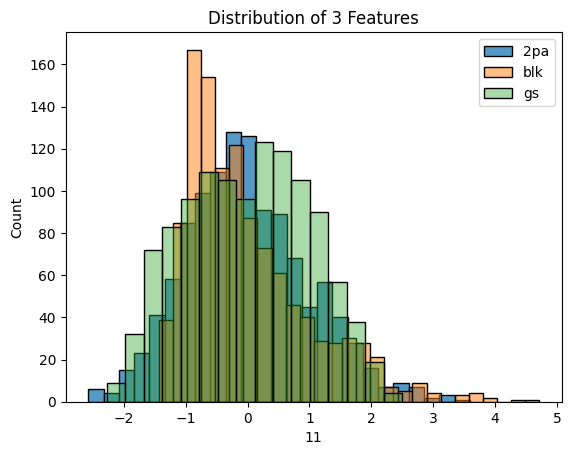

In [26]:
sns.histplot(X_scaled_df[11], label=df50_numeric.columns[11]) 
sns.histplot(X_scaled_df[22],label=df50_numeric.columns[22],alpha=.5)
sns.histplot(X_scaled_df[2],label=df50_numeric.columns[2],alpha=.4)
plt.legend()
plt.title('Distribution of 3 Features');

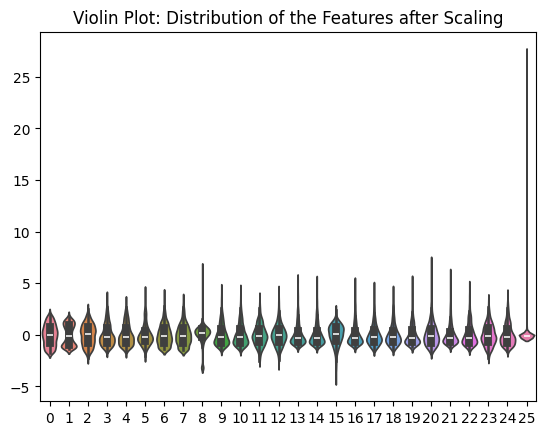

In [27]:
sns.violinplot(X_scaled_df)
plt.title('Violin Plot: Distribution of the Features after Scaling');

## Run PCA - find the principal components

## Different methods of selecting the number of components

In [28]:
from sklearn.decomposition import PCA

# select only 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## In this case I will select the number of components that explain 80% of the variance

In [29]:
pca = PCA(n_components=0.8)  # keep 80% of variance
X_pca = pca.fit_transform(X_scaled)

pca.n_components_

np.int64(5)

In [30]:
pca.explained_variance_ratio_

array([0.44407131, 0.2114355 , 0.06727047, 0.0538053 , 0.03897557])

In [31]:
np.cumsum(pca.explained_variance_ratio_)

array([0.44407131, 0.65550681, 0.72277729, 0.77658258, 0.81555816])

# This formula helps demonstrate how a principal component is calculated

PC2​=a1​⋅x1​+a2​⋅x2​+⋯+an​⋅xn​

Here we see each feature, x1 to xn, have a factor a1 to an, that multiplies it. This is called a "loading". We will see in the discussion related to Principal Component 2 that it has many features that load positively on to it. That is to say, when the feature value is higher, like 1 or 2 (standardized (mean 0, SD 1)) the value of the Principal Component increases. When the feature value is negative, like -1 or -2, the value of the Principal Component goes down. Features with negative loadings have an inverse relationship with the component: when the feature is high, the PC score decreases

A common example of inverse correlation is speed and travel time. As speed increases the travel time decreases. We will see for example as 3-point field goal attempts go up, the value of PC2 decreases

# Now we will look at the loadings per PCA component

PCA starts with standardizing features to zero mean and unit variance. This ensures that features on different scales contribute equally to the analysis. After standardizing, PCA finds linear combinations of the features, the principal components, that capture the most variance in the data. The resulting Principal Components are uncorrelated with each other. The first components usually explain the majority of the variability in the data set.

PC1 explains 44% of the variance. This indicates that when considering the 30+ feature set, reducing the dimension space using linear reduction techniques, producing the first component explains 44% of the variation within the dataset. PC2 explains 21%. This shows that as more dimensions are explained, the total amount of variance explained increases. However, each additional dimension explains less variance than the previous. So, as we add dimensions we gain more explained variance, but increase the complexity of our data. For advanced data science techniques, there is a trade off between the additional number of dimensions and their ability to explain the data set. We started with the goal of explaining 80% of the variance and in this data set it leads to 5 Principal Components. PC3 explains an additional 6.7%, PC4 explains an additional 5.4% and PC5 an additional 3.9%. This shows that the plurality of variance is explained by the first component and drives the explanation of data. Next, we will evaluate which features load onto these components.

A loading explains how one of the features contributes to the component. Some of the features are highly correlated with each other. They have similar loadings onto the component and move in the same direction. For example, PC1 has positive and higher loadings for minutes played, games started, field goals, field goals attempted, and points. In the course of playing games, these features are correlated with each other for players that are the most active. These players start the games, play the most minutes, take the most shots, and score the most points. We also see stats like rebounds, assists, and turnovers. These features also load positively onto PC1. These are additional features that are correlated with playing the game more. So, PC1 can be summarized as a player that spends considerable time playing the game and is heavily involved in the play of the game, such as shooting, assisting, or rebounding.

It is important to note that PC2 relies on different features. This is the key aspect of Principal Component Analysis. The resulting components are composites of the original feature space and reduce dimensions by finding the features that can be combined into a new single component. Here, PC2, relies on field goal percentage, 2-point field goal percentage, effective field goal percentage, offensive rebounds, total rebounds, and blocks. A player that combines these features is very different than the first. This player has high percentages and rebounds. Further research would support that this player is likely closer to the rim and is considered a "big man". A player that is not involved throughout the movement of the ball, but instead plays closer to the rim on defense to protect it and on offense for efficiency and rebounding. Additionally, the features that are related to 3-point shots, which involves standing further from the basket and behind the 3-point line, all have negative loadings. This indicates these features load on the PC2 in a similar manner, but negatively.

Finally, PC3 highlights another different combination of features. It relies on games, minutes, 3-point features, and fouls. This is the classic "3-and-D" player. This player is different than both PC1 and PC2. Component 3 is built on top of features that relate to a player that plays a lot, shoots primarily 3-point shots, is efficient in shooting, and fouls. The fouls can be explained as a defensive metric. Anecdotally, a player that fouls is playing more aggressively on defense and may also be guarding top offensive players. There is a trade-off within the sport between strong offensive players, their own defensive ability, as well as conserving energy and reducing foul exposure. Often top offensive players are not top defensive players.

Large absolute values → variable strongly influences that PC

Signs matter (direction of relationship)

In [32]:
loadings = pd.DataFrame(pca.components_.T,columns=[f"PC{i+1}" for i in range(pca.n_components_)],index=X.columns)

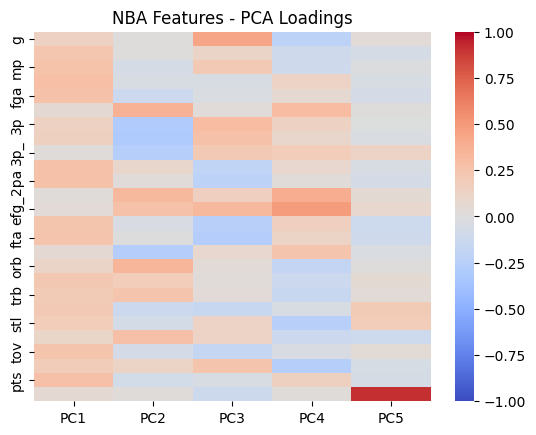

In [33]:
sns.heatmap(loadings, cmap='coolwarm',vmin=-1, vmax=1)
plt.title('NBA Features - PCA Loadings');

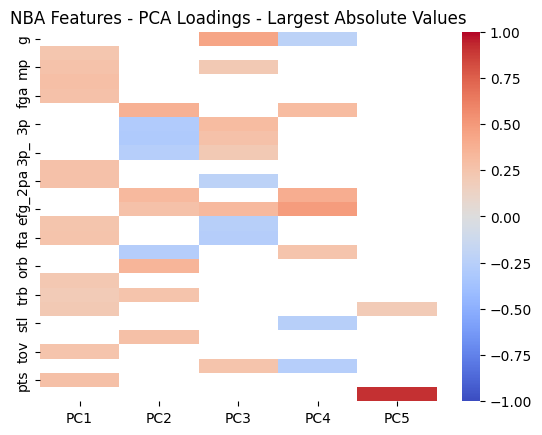

In [34]:
sns.heatmap(loadings[np.abs(loadings)>.2], cmap='coolwarm',vmin=-1, vmax=1)
plt.title('NBA Features - PCA Loadings - Largest Absolute Values');

# Create a dataframe with each player now represented by their Principal Components

In [35]:
pca_df = pd.DataFrame(
    X_pca,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.index
)

pca_df.head()

,PC1,PC2,PC3,PC4,PC5
0,0.444924,-1.163129,-1.373176,-0.713176,0.247768
1,4.068504,-2.198748,-0.165173,-0.665164,-0.574992
2,-4.025506,-0.424416,-2.171695,-0.429770,-0.101841
3,-4.145147,-2.220446,-1.756474,-0.999551,-0.109918
4,-0.428377,-2.638243,-0.677871,-2.055364,-0.076104


# Merge the original data back to get the names and original features for each row

In [36]:
df_pca50 = pca_df.merge(df50, left_index=True, right_index=True)

# Here we can see Principal Component 1 plot against Principal Component 2

Considering the largest scores for PC1 we see that it demonstrates that the component is picking up loadings from particular statistics that contribute to explaining variance in the data. When we consider the players of PC1, we see that these are actually the top performing players of the last few years. These 3 players, are considered the Most Valuable Players in the NBA and have won the award within this data set. These 3 players are considered top offensive players, play a high level of minutes and games, and have led their teams to recent championships.

For the greatest values of PC2 we observe a different set of players. These players are considered "big men" or "centers". They play a role of being the biggest player on the court, protecting the basket of the defensive side and playing near the basket on the offensive side. These players often have higher rebounds, higher blocked shots, and higher field goal percentages

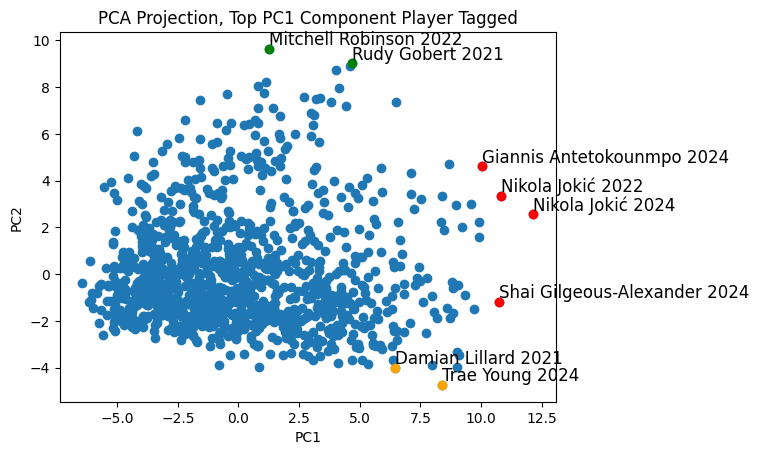

In [37]:
plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection, Top PC1 Component Player Tagged")

#label the greatest PC1 data points
for row_idx in df_pca50[df_pca50['PC1'] >10].index:
    
    text = f"{df_pca50['player'].iloc[row_idx]} {df_pca50['year'].iloc[row_idx]}"
    plt.text(df_pca50['PC1'].iloc[row_idx], df_pca50['PC2'].iloc[row_idx],
            text,
            fontsize=12, ha='left', va='bottom')

    plt.scatter(df_pca50['PC1'].iloc[row_idx], df_pca50['PC2'].iloc[row_idx],
            color="red")


#label the greatest PC2 data points 
for row_idx in df_pca50[df_pca50['PC2'] >9].index:
    
    text = f"{df_pca50['player'].iloc[row_idx]} {df_pca50['year'].iloc[row_idx]}"
    plt.text(df_pca50['PC1'].iloc[row_idx], df_pca50['PC2'].iloc[row_idx],
            text,
            fontsize=12, ha='left', va='bottom')

    plt.scatter(df_pca50['PC1'].iloc[row_idx], df_pca50['PC2'].iloc[row_idx],
            color="green")
    
#label the least PC2 data points 
for row_idx in df_pca50[df_pca50['PC2'] <-4].index:
    
    text = f"{df_pca50['player'].iloc[row_idx]} {df_pca50['year'].iloc[row_idx]}"
    plt.text(df_pca50['PC1'].iloc[row_idx], df_pca50['PC2'].iloc[row_idx],
            text,
            fontsize=12, ha='left', va='bottom')

    plt.scatter(df_pca50['PC1'].iloc[row_idx], df_pca50['PC2'].iloc[row_idx],
            color="orange")



plt.show()


# Write to the cloud for further analysis

In [38]:
# Path to service account if stored locally
SERVICE_ACCOUNT_JSON = r"..\portfolio2026-485323-70c4d609b156.json"

# Credentials to access Big Query via the service account
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_JSON)

# BigQuery client
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# BigQuery Storage client
bq_storage_client = bigquery_storage.BigQueryReadClient(credentials=credentials)

In [39]:
datasets = list(client.list_datasets())

In [40]:
if datasets:
    print("Datasets in project:")
    for dataset in datasets:
        print(dataset.dataset_id)
else:
    print("No datasets found.")


# function to see if table already exists in big query data set
def table_exists(client, full_table_id):
    try:
        client.get_table(full_table_id)
        return True
    except NotFound:
        return False

Datasets in project:
portfolio1


In [43]:
df_pca50.head()

,pc1,pc2,pc3,pc4,pc5,rk,player,pos,age,tm,...,drb,trb,ast,stl,blk,tov,pf,pts,year,trp_dbl
0,0.444924,-1.163129,-1.373176,-0.713176,0.247768,26,LaMelo Ball,PG,19,CHO,...,239,302,313,81,18,145,136,803,2021,0.0
1,4.068504,-2.198748,-0.165173,-0.665164,-0.574992,141,Anthony Edwards,SG,19,MIN,...,277,336,211,82,36,160,129,1392,2021,0.0
2,-4.025506,-0.424416,-2.171695,-0.429770,-0.101841,199,R.J. Hampton,SG,19,TOT,...,150,179,87,21,10,53,61,354,2021,0.0
3,-4.145147,-2.220446,-1.756474,-0.999551,-0.109918,296,Kira Lewis Jr.,PG,19,NOP,...,59,71,124,38,10,34,88,343,2021,0.0
4,-0.428377,-2.638243,-0.677871,-2.055364,-0.076104,309,Théo Maledon,PG,19,OKC,...,186,211,227,56,11,141,126,658,2021,0.0


In [42]:
df_pca50.columns = df_pca50.columns.str.lower().str.strip().str.replace(r"[^\w]+","_", regex=True)

In [44]:
# Write to bigquery

# Write truncate will overwrite the table instead of appending
job_config = bigquery.LoadJobConfig(write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
                                    autodetect=True)

full_table_id = f"{credentials.project_id}.portfolio1.pca_data"

if table_exists(client, full_table_id):
    print(f"Table {full_table_id} already exists.")
    print("Overwriting existing table...")
else:
    print("Creating new table...")

load_job = client.load_table_from_dataframe(df_pca50, full_table_id, job_config=job_config)
load_job.result()

Creating new table...


LoadJob<project=portfolio2026-485323, location=US, id=ba45bbbe-a32d-4f16-b644-d88a79ced2c6>

# DF50 write to the cloud

In [45]:
df50.columns = df50.columns.str.lower().str.strip().str.replace(r"[^\w]+","_", regex=True)

In [46]:
# Write to bigquery

# Write truncate will overwrite the table instead of appending
job_config = bigquery.LoadJobConfig(write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
                                    autodetect=True)

full_table_id = f"{credentials.project_id}.portfolio1.df50"

if table_exists(client, full_table_id):
    print(f"Table {full_table_id} already exists.")
    print("Overwriting existing table...")
else:
    print("Creating new table...")

load_job = client.load_table_from_dataframe(df50, full_table_id, job_config=job_config)
load_job.result()

Creating new table...


LoadJob<project=portfolio2026-485323, location=US, id=10dd1975-cad2-4e01-93b3-4fa143e05cee>